# Lab 3.1 - Algorytmy genetyczne
## Dawid Przybyliński 298836

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
class evolution:
    
    def __init__(self, population_size, chr_size, target_function, init_method = 'binary'):
        self.n = population_size
        self.m = chr_size
        self.target = target_function
        self.best = None
        self.generation_mean = []
        
        # initialize random generation
        init_args = init_method.split()
        if init_args[0] == 'binary': # random bits
            self.generation = np.random.choice([0, 1], size=(self.n, self.m), p=[0.5,0.5])
        elif init_args[0] == 'uniform': # [uniform, start, stop]
            self.generation = np.random.uniform(float(init_args[1]), float(init_args[2]), (self.n, self.m))
        else: # random uniforms(-8,8)
            self.generation = np.random.uniform(-8, 8, (self.n, self.m))
            
    
    def evolve(self, epochs = 100, p_cross = 0.7, p_mutate = 0.2):
        """
        główna funkcja przeprowadzająca ewolucję i szukająca minimum
        """
        iteration_counter = 0
        current_best_value = -1
        while True:
            
            # check stop condition 
            if iteration_counter == epochs:
                return self.target(self.best, arguments = True)
            iteration_counter += 1
            
            # crossover
            parents = self.generation[np.random.choice(self.n, int(np.floor(p_cross*self.n)), replace=False), :]
            crossed = self.crossover(parents)
            population = np.vstack((self.generation, crossed))
            pop_size = population.shape[0]
            
            # mutation
            mutated = population[np.random.choice(pop_size, int(np.floor(p_mutate*pop_size)), replace=False), :]
            mutated = self.mutate(mutated)
            population = np.vstack((population, mutated))
            
            # evaluation
            values = np.asarray([self.target(osobnik) for osobnik in population])
            self.generation_mean.append(np.mean(values))
            best_value_index = np.argmax(values)
            if values[best_value_index] > current_best_value:
                self.best = population[best_value_index]
                current_best_value = values[best_value_index]
            
            # selection
            prob = values/values.sum()
            choices = np.random.choice([i for i in range(population.shape[0])], size=self.n, p=prob)
            self.generation = np.asarray([population[choice] for choice in choices])
            
            
            
    def crossover(self,parents):
        """
        krzyżowanie, narazie tylko jednopunktowe
        dla podanych rodziców krzyżujemy 1. z 2., 3. z 4., i tak dalej
        """
        children = []
        for i in range(0, parents.shape[0]-1, 2):
            [child_1, child_2] = self.cross(parents[i], parents[i+1])
            children.append(child_1)
            children.append(child_2)
        return np.asarray(children)
            
            
    def cross(self,x,y):
        """
        krzyżowanie jednopunktowe, punkt podziału jest losowy z przedziału [1,len-1]
        """
        split = random.randint(1,len(x)-1)
        child_1 = np.concatenate((x[0:split], y[split:]))
        child_2 = np.concatenate((y[0:split], x[split:]))
        return [child_1, child_2]
    
    def mutate(self, to_mutate):
        """
        mutacja gaussowska, przesunięcie osobnika o N(0,1)^self.m
        """
        for i, osobnik in enumerate(to_mutate):
            for j, gen in enumerate(osobnik):
                to_mutate[i][j] += np.random.normal(0,1)
        return to_mutate


# Testy
## funkcja kwadratowa w $R^3$: $f(x,y,z) = x^2+y^2+2z^2$

In [3]:
def square_fun(x,y,z):
    """funkcja kwadratowa - pierwsza funckja testowa"""
    return (x**2) + (y**2) + 2*(z**2)

In [4]:
def eval_1(osobnik, arguments = False):
    """przekształcenie funkcji testowej - chcemy szukać minimum funkcji o watościach dodatnich"""
    target = square_fun(osobnik[0],osobnik[1],osobnik[2])
    if arguments:
        return (osobnik,1/target)
    return 1/target   

Użyjemy algorytmu 10 razy, wynik jest w formacie $([x,y,z],1/f(x,y,z))$

In [5]:
for i in range(10):
    evo = evolution(10, 3, eval_1, init_method='uniform -20 20')
    print(evo.evolve())

(array([ 0.19243234, -0.00804736,  0.10319587]), 17.12512245383946)
(array([-0.07825191, -0.22730545,  0.06981769]), 14.806008821299788)
(array([ 0.05032307,  0.28114854, -0.09076049]), 10.198686261950195)
(array([-0.08953996, -0.03454124, -0.10636805]), 31.408192098907136)
(array([-0.09178591, -0.19316162,  0.04516004]), 20.074305720524862)
(array([-0.21492139, -0.0099627 , -0.02751919]), 20.91828306983451)
(array([ 0.05449847,  0.08391846, -0.02196765]), 91.09503045789647)
(array([ 0.05002984, -0.02986591,  0.02848059]), 199.312537530426)
(array([-0.13471216,  0.1025894 , -0.10317177]), 20.015701620814152)
(array([ 0.09321254,  0.00026068, -0.08945955]), 40.49457503653326)


Algorytm działa poprawnie (już dla 10 osobników i 100 iteracji) - rozwiązanie jest blisko minimum globalnego w (0,0,0). Sprawdźmy co się dzieje ze średnim wynikiem w kolejnych epokach dla odległego punktu początkowego (i 100 osobników). Średni wy

(array([-0.00059811, -0.00667217,  0.02184906]), 1000.3619522362252)


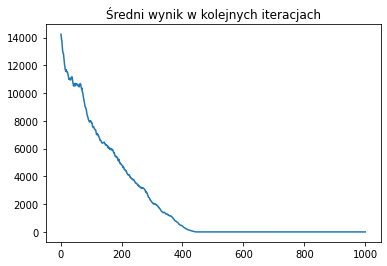

In [6]:
evo = evolution(100, 3, eval_1, init_method='uniform 50 70')
print(evo.evolve(1000))
plt.plot(np.linspace(1,1000,1000), [1/y for y in evo.generation_mean])
plt.title("Średni wynik w kolejnych iteracjach")
plt.show()

## funkcja Rastrigina w $R^5$: $f(x) = 5A + \sum_{i=1}^5(x_i^2-Acos(\pi x_i))$, $A=10$

In [7]:
def rastrigin(x, A=10):
    """funckja rastrigina"""
    return (A*len(x) + np.sum(x**2 - A*np.cos(2*np.pi*x)))

In [8]:
def eval_2(osobnik, arguments = False):
    target = rastrigin(osobnik)
    if arguments:
        return (osobnik, 1/target)
    return 1/target   

Tutaj ponownie przetestujemy algorytm 10 razy, wynik w formacie $(x, 1/f(x))$

In [9]:
for i in range(10):
    evo = evolution(100, 3, eval_2, init_method='dupa')
    print(evo.evolve())

(array([ 0.00660023, -1.00768976,  0.00411085]), 0.9623689925803305)
(array([-0.03957347, -0.0195317 , -0.0059446 ]), 2.5529478567663775)
(array([0.02390459, 0.02623224, 0.02044605]), 3.0103232439048013)
(array([-0.00630777, -0.0190067 , -0.02177628]), 5.766652447269753)
(array([0.01882374, 0.0167071 , 0.00513111]), 7.647344666518363)
(array([-0.00189608, -0.01301991, -0.00961372]), 18.99111820912669)
(array([ 0.04450751, -0.02736297,  0.01730619]), 1.6722499026461375)
(array([-0.01775694, -0.01291917, -0.0047648 ]), 9.991145829383854)
(array([0.00101319, 0.0210855 , 0.02522399]), 4.667564959768987)
(array([-0.00135303, -0.01886182, -0.05312525]), 1.5983895684701193)


Ponownie rozwiązania są bliko minimum globalnego w wektorze zerowym. Poniżej wykres średniej dla odległego punktu początkowego:

(array([ 0.01981733, -0.01289038, -0.01474686]), 6.49879801350009)


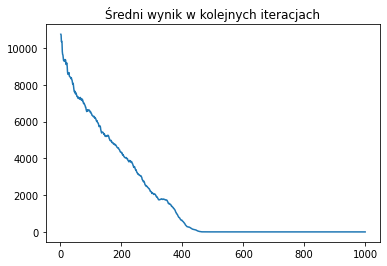

In [10]:
evo = evolution(100, 3, eval_2, init_method='uniform 50 70')
print(evo.evolve(1000))
plt.plot(np.linspace(1,1000,1000), [1/y for y in evo.generation_mean])
plt.title("Średni wynik w kolejnych iteracjach")
plt.show()

Szybkość zbieżności jest podobna co dla funkcji kwadratowej (około 400 epok). Tak więc algorytm dosyć szybko zbiega, nawet dla małych genotypów (spodziewam się że zakodowanie punktów większą liczbą genów usprawniłoby proces). Niemniej eksperymenty można zdecydowanie uznać za zakończone sukcesem.